In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 150)


In [ ]:
path = "/content/drive/MyDrive/NEW_HEALTHCARE/"


In [ ]:
df_allergies = pd.read_csv(path + "allergies.csv")
df_careplans = pd.read_csv(path + "careplans.csv")
df_conditions = pd.read_csv(path + "conditions.csv")
df_devices = pd.read_csv(path + "devices.csv")
df_encounters = pd.read_csv(path + "encounters.csv")
df_imaging = pd.read_csv(path + "imaging_studies.csv")
df_immunizations = pd.read_csv(path + "immunizations.csv")
df_medications = pd.read_csv(path + "medications.csv")
df_observations = pd.read_csv(path + "observations.csv")
df_orgs = pd.read_csv(path + "organizations.csv")
df_patients = pd.read_csv(path + "patients.csv")
df_payer_trans = pd.read_csv(path + "payer_transitions.csv")
df_payers = pd.read_csv(path + "payers.csv")
df_procedures = pd.read_csv(path + "procedures.csv")
df_providers = pd.read_csv(path + "providers.csv")


In [ ]:
datasets = {
    "allergies": df_allergies,
    "careplans": df_careplans,
    "conditions": df_conditions,
    "devices": df_devices,
    "encounters": df_encounters,
    "imaging_studies": df_imaging,
    "immunizations": df_immunizations,
    "medications": df_medications,
    "observations": df_observations,
    "organizations": df_orgs,
    "patients": df_patients,
    "payer_transitions": df_payer_trans,
    "payers": df_payers,
    "procedures": df_procedures,
        "providers": df_providers
}


In [ ]:
# Missing Value Handling (Patients Dataset)
# --------------------------
df = datasets["patients"]


In [ ]:
# Age → numerical → fill with median
if "Age" in df.columns:
    df["Age"].fillna(df["Age"].median(), inplace=True)

# Gender → categorical → fill with mode
if "Gender" in df.columns:
    df["Gender"].fillna(df["Gender"].mode()[0], inplace=True)

# Blood Type → categorical → fill with mode
if "Blood Type" in df.columns:
    df["Blood Type"].fillna(df["Blood Type"].mode()[0], inplace=True)

# Medical Condition → categorical → fill with 'Unknown'
if "Medical Condition" in df.columns:
    df["Medical Condition"].fillna("Unknown", inplace=True)

# Admission/Discharge Dates → forward fill
for col in ["Date of Admission", "Discharge Date"]:
    if col in df.columns:
        df[col].fillna(method="ffill", inplace=True)

# Billing Amount → numerical → fill with median
if "Billing Amount" in df.columns:
    df["Billing Amount"].fillna(df["Billing Amount"].median(), inplace=True)

# Medication → categorical → fill with 'Unknown'
if "Medication" in df.columns:
    df["Medication"].fillna("Unknown", inplace=True)

# Test Results → numerical → fill with mean
if "Test Results" in df.columns:
    df["Test Results"].fillna(df["Test Results"].mean(), inplace=True)

# Replace updated patients dataframe back
datasets["patients"] = df


## building an RNN/LSTM model

In [ ]:
# Convert BIRTHDATE (and DEATHDATE if useful)
df_patients['BIRTHDATE'] = pd.to_datetime(df_patients['BIRTHDATE'], errors='coerce')
df_patients['DEATHDATE'] = pd.to_datetime(df_patients['DEATHDATE'], errors='coerce')

# Compute age at last encounter (or today if alive)
today = pd.to_datetime("today")
df_patients['AGE'] = ((df_patients['DEATHDATE'].fillna(today) - df_patients['BIRTHDATE']).dt.days / 365.25).astype(int)

# Keep only needed columns
df_patients = df_patients[['Id', 'AGE', 'GENDER']]

In [ ]:
df_patients.head()

,Id,AGE,GENDER
0,1d604da9-9a81-4ba9-80c2-de3375d59b40,36,M
1,034e9e3b-2def-4559-bb2a-7850888ae060,41,M
2,10339b10-3cd1-4ac3-ac13-ec26728cb592,33,M
3,8d4c4326-e9de-4f45-9a4c-f8c36bff89ae,47,F
4,f5dcd418-09fe-4a2f-baa0-3da800bd8c3a,28,M


In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
# Check what kinds of observation descriptions exist
print(df_observations['DESCRIPTION'].unique()[:50])

['Body Height'
 'Pain severity - 0-10 verbal numeric rating [Score] - Reported'
 'Body Weight' 'Body Mass Index' 'Diastolic Blood Pressure'
 'Systolic Blood Pressure' 'Heart rate' 'Respiratory rate'
 'Body temperature'
 'Body mass index (BMI) [Percentile] Per age and gender'
 'Leukocytes [#/volume] in Blood by Automated count'
 'Tobacco smoking status NHIS'
 'Erythrocytes [#/volume] in Blood by Automated count'
 'Hemoglobin [Mass/volume] in Blood'
 'Hematocrit [Volume Fraction] of Blood by Automated count'
 'MCV [Entitic volume] by Automated count'
 'MCH [Entitic mass] by Automated count'
 'MCHC [Mass/volume] by Automated count'
 'Erythrocyte distribution width [Entitic volume] by Automated count'
 'Platelets [#/volume] in Blood by Automated count'
 'Platelet distribution width [Entitic volume] in Blood by Automated count'
 'Platelet mean volume [Entitic volume] in Blood by Automated count'
 'Total Cholesterol' 'Triglycerides' 'Low Density Lipoprotein Cholesterol'
 'High Density Lipopr

In [ ]:
# Step 3: Select actual vitals
# -----------------------------
vital_features = [
    "Systolic Blood Pressure",
    "Diastolic Blood Pressure",
    "Heart rate",
    "Respiratory rate",
    "Body temperature",
    "Body Weight",
]

In [ ]:
obs_relevant = df_observations[df_observations['DESCRIPTION'].isin(vital_features)]
obs_relevant = obs_relevant[['PATIENT', 'DATE', 'DESCRIPTION', 'VALUE']]

In [ ]:
obs_relevant

,PATIENT,DATE,DESCRIPTION,VALUE
2,034e9e3b-2def-4559-bb2a-7850888ae060,2012-01-23T17:45:28Z,Body Weight,87.8
4,034e9e3b-2def-4559-bb2a-7850888ae060,2012-01-23T17:45:28Z,Diastolic Blood Pressure,82.0
5,034e9e3b-2def-4559-bb2a-7850888ae060,2012-01-23T17:45:28Z,Systolic Blood Pressure,119.0
6,034e9e3b-2def-4559-bb2a-7850888ae060,2012-01-23T17:45:28Z,Heart rate,77.0
7,034e9e3b-2def-4559-bb2a-7850888ae060,2012-01-23T17:45:28Z,Respiratory rate,14.0
...,...,...,...,...
299656,fc817953-cc8b-45db-9c85-7c0ced8fa90d,2019-07-13T17:27:52Z,Body Weight,76.6
299658,fc817953-cc8b-45db-9c85-7c0ced8fa90d,2019-07-13T17:27:52Z,Diastolic Blood Pressure,76.0
299659,fc817953-cc8b-45db-9c85-7c0ced8fa90d,2019-07-13T17:27:52Z,Systolic Blood Pressure,123.0
299660,fc817953-cc8b-45db-9c85-7c0ced8fa90d,2019-07-13T17:27:52Z,Heart rate,84.0


In [ ]:
obs_relevant.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64381 entries, 2 to 299661
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PATIENT      64381 non-null  object
 1   DATE         64381 non-null  object
 2   DESCRIPTION  64381 non-null  object
 3   VALUE        64381 non-null  object
dtypes: object(4)
memory usage: 4.5+ MB


In [ ]:
obs_relevant['VALUE'] = pd.to_numeric(obs_relevant['VALUE'], errors='coerce')

In [ ]:
# Step 4: Pivot observations
# -----------------------------
obs_pivot = obs_relevant.pivot_table(
    index=['PATIENT', 'DATE'],
    columns='DESCRIPTION',
    values='VALUE',
    aggfunc='mean'
).reset_index()

obs_pivot.columns.name = None

In [ ]:
# Step 5: Merge demographics
# -----------------------------
obs_pivot = obs_pivot.merge(df_patients, left_on='PATIENT', right_on='Id', how='left')
obs_pivot['GENDER'] = LabelEncoder().fit_transform(obs_pivot['GENDER'])
obs_pivot.drop('Id', axis=1, inplace=True)

In [ ]:
obs_pivot

,PATIENT,DATE,Body Weight,Body temperature,Diastolic Blood Pressure,Heart rate,Respiratory rate,Systolic Blood Pressure,AGE,GENDER
0,00185faa-2760-4218-9bf5-db301acf8274,2010-11-09T15:06:37Z,26.8,NaN,86.0,98.0,15.0,124.0,21,1
1,00185faa-2760-4218-9bf5-db301acf8274,2011-11-15T15:06:37Z,30.9,NaN,75.0,93.0,13.0,126.0,21,1
2,00185faa-2760-4218-9bf5-db301acf8274,2012-08-03T15:06:37Z,NaN,38.0,NaN,NaN,NaN,NaN,21,1
3,00185faa-2760-4218-9bf5-db301acf8274,2012-10-14T15:06:37Z,NaN,37.5,NaN,NaN,NaN,NaN,21,1
4,00185faa-2760-4218-9bf5-db301acf8274,2012-11-20T15:06:37Z,33.8,NaN,77.0,82.0,14.0,133.0,21,1
...,...,...,...,...,...,...,...,...,...,...
13751,ffcfa457-00c2-4405-9837-ac2781549c7e,2018-05-14T09:02:32Z,9.1,NaN,84.0,70.0,13.0,123.0,9,1
13752,ffcfa457-00c2-4405-9837-ac2781549c7e,2018-05-21T09:02:32Z,9.1,NaN,71.0,95.0,16.0,107.0,9,1
13753,ffcfa457-00c2-4405-9837-ac2781549c7e,2018-11-19T09:02:32Z,9.8,NaN,74.0,99.0,13.0,120.0,9,1
13754,ffcfa457-00c2-4405-9837-ac2781549c7e,2019-05-20T09:02:32Z,11.1,NaN,82.0,71.0,12.0,134.0,9,1


In [ ]:
# Step 6: Sort & fill missing
# -----------------------------
obs_pivot['DATE'] = pd.to_datetime(obs_pivot['DATE'], errors='coerce')
obs_pivot = obs_pivot.sort_values(['PATIENT', 'DATE'])

vital_cols = vital_features
obs_pivot[vital_cols] = obs_pivot.groupby('PATIENT')[vital_cols].ffill().bfill()

In [ ]:
obs_pivot

,PATIENT,DATE,Body Weight,Body temperature,Diastolic Blood Pressure,Heart rate,Respiratory rate,Systolic Blood Pressure,AGE,GENDER
0,00185faa-2760-4218-9bf5-db301acf8274,2010-11-09 15:06:37+00:00,26.8,38.0,86.0,98.0,15.0,124.0,21,1
1,00185faa-2760-4218-9bf5-db301acf8274,2011-11-15 15:06:37+00:00,30.9,38.0,75.0,93.0,13.0,126.0,21,1
2,00185faa-2760-4218-9bf5-db301acf8274,2012-08-03 15:06:37+00:00,30.9,38.0,75.0,93.0,13.0,126.0,21,1
3,00185faa-2760-4218-9bf5-db301acf8274,2012-10-14 15:06:37+00:00,30.9,37.5,75.0,93.0,13.0,126.0,21,1
4,00185faa-2760-4218-9bf5-db301acf8274,2012-11-20 15:06:37+00:00,33.8,37.5,77.0,82.0,14.0,133.0,21,1
...,...,...,...,...,...,...,...,...,...,...
13751,ffcfa457-00c2-4405-9837-ac2781549c7e,2018-05-14 09:02:32+00:00,9.1,37.3,84.0,70.0,13.0,123.0,9,1
13752,ffcfa457-00c2-4405-9837-ac2781549c7e,2018-05-21 09:02:32+00:00,9.1,37.3,71.0,95.0,16.0,107.0,9,1
13753,ffcfa457-00c2-4405-9837-ac2781549c7e,2018-11-19 09:02:32+00:00,9.8,37.3,74.0,99.0,13.0,120.0,9,1
13754,ffcfa457-00c2-4405-9837-ac2781549c7e,2019-05-20 09:02:32+00:00,11.1,37.3,82.0,71.0,12.0,134.0,9,1


In [ ]:
# Ensure data is sorted
obs_pivot = obs_pivot.sort_values(by=["PATIENT", "DATE"])


In [ ]:
SEQ_LEN = 10  # number of timesteps per sequence


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## Predict Next Vitals

## ADDING DIFFERENT DATASETS

In [ ]:
import pandas as pd
import numpy as np

# load CSVs (paths as needed)
obs = pd.read_csv("/content/drive/MyDrive/NEW_HEALTHCARE/observations.csv")            # has PATIENT, DATE, DESCRIPTION, VALUE
enc = pd.read_csv("/content/drive/MyDrive/NEW_HEALTHCARE/encounters.csv")              # has Id, PATIENT, START, STOP, ENCOUNTERCLASS, CODE, DESCRIPTION, etc.
meds = pd.read_csv("/content/drive/MyDrive/NEW_HEALTHCARE/medications.csv")            # PATIENT, START, STOP, DESCRIPTION (drug)
procs = pd.read_csv("/content/drive/MyDrive/NEW_HEALTHCARE/procedures.csv")            # PATIENT, DATE, DESCRIPTION, ENCOUNTER
conds = pd.read_csv("/content/drive/MyDrive/NEW_HEALTHCARE/conditions.csv")            # PATIENT, START, STOP, DESCRIPTION

# normalize date columns
obs['DATE'] = pd.to_datetime(obs['DATE'], errors='coerce')
enc['START'] = pd.to_datetime(enc['START'], errors='coerce')
enc['STOP']  = pd.to_datetime(enc['STOP'],  errors='coerce')
meds['START'] = pd.to_datetime(meds['START'], errors='coerce')
procs['DATE'] = pd.to_datetime(procs['DATE'], errors='coerce')
conds['START'] = pd.to_datetime(conds['START'], errors='coerce')


In [ ]:
# obs_pivot: columns ['PATIENT','DATE', 'Systolic Blood Pressure', 'Heart rate', ...]
vital_cols = ["Systolic Blood Pressure","Diastolic Blood Pressure","Heart rate","Respiratory rate","Body temperature","Body Weight"]
obs_pivot = obs_pivot.sort_values(['PATIENT','DATE'])

# rolling stats and deltas (window in previous timesteps, e.g., 3)
window = 3
for col in vital_cols:
    obs_pivot[f'{col}_rolling_mean'] = obs_pivot.groupby('PATIENT')[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
    obs_pivot[f'{col}_rolling_std']  = obs_pivot.groupby('PATIENT')[col].transform(lambda x: x.rolling(window, min_periods=1).std().fillna(0))
    obs_pivot[f'{col}_delta'] = obs_pivot.groupby('PATIENT')[col].diff().fillna(0)


In [ ]:
# time gap in hours between consecutive observations for same patient
obs_pivot['time_gap_hours'] = obs_pivot.groupby('PATIENT')['DATE'].diff().dt.total_seconds().div(3600).fillna(0)

# admission-relative time (if you merge with encounters)
# Merge encounters start time per observation by matching PATIENT & nearest earlier encounter START
enc_small = enc[['Id','PATIENT','START']].rename(columns={'Id':'ENCOUNTER_ID','START':'ENCOUNTER_START'})
obs_pivot = pd.merge_asof(obs_pivot.sort_values('DATE'),
                          enc_small.sort_values('ENCOUNTER_START'),
                          left_on='DATE', right_on='ENCOUNTER_START', by='PATIENT', direction='backward')
obs_pivot['time_from_enc_start_hours'] = (obs_pivot['DATE'] - obs_pivot['ENCOUNTER_START']).dt.total_seconds().div(3600).fillna(0)

# hour of day cyclic encoding
obs_pivot['hour'] = obs_pivot['DATE'].dt.hour.fillna(0).astype(int)
obs_pivot['hour_sin'] = np.sin(2*np.pi*obs_pivot['hour']/24)
obs_pivot['hour_cos'] = np.cos(2*np.pi*obs_pivot['hour']/24)


In [ ]:
# Define simple drug keyword sets (use domain knowledge / Rx vocab ideally)
beta_keywords = ['beta', 'metoprolol','propanolol','atenolol','bisoprolol']
vaso_keywords = ['norepinephrine','epinephrine','vasopressin','dopamine']
sedative_keywords = ['midazolam','propofol','lorazepam','diazepam','fentanyl']

# normalize med descriptions to lowercase
meds['desc_l'] = meds['DESCRIPTION'].str.lower().fillna('')

# create per-med boolean table for med occurrences per patient-date (within last 24h)
meds['START_DATE'] = pd.to_datetime(meds['START'])
meds_small = meds[['PATIENT','START_DATE','desc_l']].dropna()

# mark med class by keyword
meds_small['beta_blocker'] = meds_small['desc_l'].str.contains('|'.join(beta_keywords), na=False).astype(int)
meds_small['vasopressor']  = meds_small['desc_l'].str.contains('|'.join(vaso_keywords), na=False).astype(int)
meds_small['sedative']     = meds_small['desc_l'].str.contains('|'.join(sedative_keywords), na=False).astype(int)

# aggregate per patient-date (you could round to day)
meds_agg = meds_small.groupby(['PATIENT', 'START_DATE'])[['beta_blocker','vasopressor','sedative']].sum().reset_index()
# merge to obs_pivot by nearest earlier med within 24h window (example approach)
meds_agg = meds_agg.sort_values('START_DATE')
obs_pivot = pd.merge_asof(obs_pivot.sort_values('DATE'), meds_agg.rename(columns={'START_DATE':'med_time'}).sort_values('med_time'),
                          left_on='DATE', right_on='med_time', by='PATIENT', direction='backward', tolerance=pd.Timedelta('1D'))
# fill NaNs with 0
obs_pivot[['beta_blocker','vasopressor','sedative']] = obs_pivot[['beta_blocker','vasopressor','sedative']].fillna(0)


In [ ]:
# mark if a procedure occurred within last 24 hours
procs_small = procs[['PATIENT','DATE']].dropna().sort_values('DATE')
obs_pivot = pd.merge_asof(obs_pivot.sort_values('DATE'),
                          procs_small.rename(columns={'DATE':'proc_time'}).sort_values('proc_time'),
                          left_on='DATE', right_on='proc_time', by='PATIENT', direction='backward', tolerance=pd.Timedelta('1D'))
obs_pivot['proc_recent'] = (~obs_pivot['proc_time'].isna()).astype(int)
obs_pivot = obs_pivot.drop(columns=['proc_time'])


In [ ]:
conds['desc_l'] = conds['DESCRIPTION'].str.lower().fillna('')
obs_pivot['has_hypertension'] = obs_pivot['PATIENT'].isin(conds[conds['desc_l'].str.contains('hypertension')]['PATIENT']).astype(int)
obs_pivot['has_diabetes'] = obs_pivot['PATIENT'].isin(conds[conds['desc_l'].str.contains('diabetes')]['PATIENT']).astype(int)


In [ ]:
obs_pivot.head()

,PATIENT,DATE,Body Weight,Body temperature,Diastolic Blood Pressure,Heart rate,Respiratory rate,Systolic Blood Pressure,AGE,GENDER,Systolic Blood Pressure_rolling_mean,Systolic Blood Pressure_rolling_std,Systolic Blood Pressure_delta,Diastolic Blood Pressure_rolling_mean,Diastolic Blood Pressure_rolling_std,Diastolic Blood Pressure_delta,Heart rate_rolling_mean,Heart rate_rolling_std,Heart rate_delta,Respiratory rate_rolling_mean,Respiratory rate_rolling_std,Respiratory rate_delta,Body temperature_rolling_mean,Body temperature_rolling_std,Body temperature_delta,Body Weight_rolling_mean,Body Weight_rolling_std,Body Weight_delta,time_gap_hours,ENCOUNTER_ID,ENCOUNTER_START,time_from_enc_start_hours,hour,hour_sin,hour_cos,med_time,beta_blocker,vasopressor,sedative,proc_recent,has_hypertension,has_diabetes
0,67156a1d-2e86-42e0-a81c-6ce3af24aca4,1916-05-05 23:35:03+00:00,14.0,38.3,75.0,87.0,14.0,102.0,12,1,102.000000,0.000000,0.0,75.000000,0.000000,0.0,87.000000,0.000000,0.0,14.0,0.000000,0.0,38.3,0.0,0.0,14.000000,0.000000,0.0,0.0,8fabe01e-fbda-496d-8bb2-7e426070814c,1916-05-05 23:35:03+00:00,0.0,23,-0.258819,0.965926,NaT,0.0,0.0,0.0,1,0,0
1,67156a1d-2e86-42e0-a81c-6ce3af24aca4,1916-11-03 23:35:03+00:00,15.9,38.3,78.0,84.0,13.0,138.0,12,1,120.000000,25.455844,36.0,76.500000,2.121320,3.0,85.500000,2.121320,-3.0,13.5,0.707107,-1.0,38.3,0.0,0.0,14.950000,1.343503,1.9,4368.0,7ad88525-8907-4136-b8fa-22cb9f2ba273,1916-11-03 23:35:03+00:00,0.0,23,-0.258819,0.965926,NaT,0.0,0.0,0.0,0,0,0
2,67156a1d-2e86-42e0-a81c-6ce3af24aca4,1917-05-04 23:35:03+00:00,17.9,38.3,81.0,79.0,15.0,112.0,12,1,117.333333,18.583146,-26.0,78.000000,3.000000,3.0,83.333333,4.041452,-5.0,14.0,1.000000,2.0,38.3,0.0,0.0,15.933333,1.950214,2.0,4368.0,87f5a1b7-852e-47a5-98f8-10c325710040,1917-05-04 23:35:03+00:00,0.0,23,-0.258819,0.965926,NaT,0.0,0.0,0.0,1,0,0
3,67156a1d-2e86-42e0-a81c-6ce3af24aca4,1918-05-10 23:35:03+00:00,20.7,38.3,69.0,72.0,14.0,104.0,12,1,118.000000,17.776389,-8.0,76.000000,6.244998,-12.0,78.333333,6.027714,-7.0,14.0,1.000000,-1.0,38.3,0.0,0.0,18.166667,2.411086,2.8,8904.0,d9996c76-2dd7-4d15-b873-4d5491e66f85,1918-05-10 23:35:03+00:00,0.0,23,-0.258819,0.965926,NaT,0.0,0.0,0.0,1,0,0
4,67156a1d-2e86-42e0-a81c-6ce3af24aca4,1919-05-16 23:35:03+00:00,22.3,38.3,86.0,92.0,13.0,123.0,12,1,113.000000,9.539392,19.0,78.666667,8.736895,17.0,81.000000,10.148892,20.0,14.0,1.000000,-1.0,38.3,0.0,0.0,20.300000,2.227106,1.6,8904.0,f6f7a3b8-d2b1-433e-bc59-4c1a391b95d3,1919-05-16 23:35:03+00:00,0.0,23,-0.258819,0.965926,NaT,0.0,0.0,0.0,0,0,0


In [ ]:
import numpy as np
import pandas as pd

# Copy the pivot
obs_feat = obs_pivot.copy()

# Ensure sorted by patient/date
obs_feat = obs_feat.sort_values(["PATIENT", "DATE"])

# Pick continuous features only
vital_features = ["Body Weight", "Body temperature",
                  "Diastolic Blood Pressure", "Systolic Blood Pressure",
                  "Heart rate", "Respiratory rate"]

# For each patient, compute engineered features
engineered = []
for pid, group in obs_feat.groupby("PATIENT"):
    g = group.copy()
    g = g.sort_values("DATE")

    # rolling mean (window=3)
    for col in vital_features:
        g[f"{col}_rollmean3"] = g[col].rolling(window=3, min_periods=1).mean()

    # deltas (difference between consecutive values)
    for col in vital_features:
        g[f"{col}_delta"] = g[col].diff().fillna(0)

    # time gaps (in days between observations)
    g["time_gap"] = g["DATE"].diff().dt.total_seconds().div(3600*24).fillna(0)

    engineered.append(g)

obs_engineered = pd.concat(engineered).reset_index(drop=True)

print("Engineered feature sample:")
print(obs_engineered.head())


Engineered feature sample:
                                PATIENT                      DATE  Body Weight  Body temperature  Diastolic Blood Pressure  Heart rate  \
0  00185faa-2760-4218-9bf5-db301acf8274 2010-11-09 15:06:37+00:00         26.8              38.0                      86.0        98.0   
1  00185faa-2760-4218-9bf5-db301acf8274 2011-11-15 15:06:37+00:00         30.9              38.0                      75.0        93.0   
2  00185faa-2760-4218-9bf5-db301acf8274 2012-08-03 15:06:37+00:00         30.9              38.0                      75.0        93.0   
3  00185faa-2760-4218-9bf5-db301acf8274 2012-10-14 15:06:37+00:00         30.9              37.5                      75.0        93.0   
4  00185faa-2760-4218-9bf5-db301acf8274 2012-11-20 15:06:37+00:00         33.8              37.5                      77.0        82.0   

   Respiratory rate  Systolic Blood Pressure  AGE  GENDER  Systolic Blood Pressure_rolling_mean  Systolic Blood Pressure_rolling_std  \
0       

In [ ]:
SEQ_LEN = 10

# features to feed'
feature_cols = [c for c in obs_engineered.columns if c not in ["PATIENT","DATE","AGE","GENDER","ENCOUNTER_ID","ENCOUNTER_START","med_time"]]

sequences, labels = [], []
for pid, group in obs_engineered.groupby("PATIENT"):
    group = group.sort_values("DATE")
    data = group[feature_cols].values

    for i in range(len(data) - SEQ_LEN):
        seq = data[i:i+SEQ_LEN]
        target = data[i+SEQ_LEN][0:len(vital_features)]  # only predict raw vitals
        sequences.append(seq)
        labels.append(target)

X = np.array(sequences)
y = np.array(labels)

print("X shape:", X.shape, "y shape:", y.shape)


X shape: (3507, 10, 42) y shape: (3507, 6)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def build_stacked_lstm(seq_len, n_features, hidden_units=64, dropout=0.3):
    model = Sequential([
        LSTM(hidden_units, return_sequences=True, input_shape=(seq_len, n_features)),
        Dropout(dropout),
        LSTM(hidden_units),
        Dense(32, activation="relu"),
        Dropout(dropout),
        Dense(y.shape[1])   # predict vitals only
    ])
    model.compile(optimizer=Adam(1e-3), loss="mse", metrics=["mae"])
    return model

model = build_stacked_lstm(SEQ_LEN, X.shape[2])
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=30,
                    batch_size=32,
                    verbose=1)

# Evaluation
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Stacked LSTM Test Loss: {loss:.4f}, MAE: {mae:.4f}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 5491.7539 - mae: 64.5377 - val_loss: 3136.9456 - val_mae: 46.3424
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2372.4470 - mae: 38.6795 - val_loss: 757.5512 - val_mae: 17.9419
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 738.9990 - mae: 19.6555 - val_loss: 293.9051 - val_mae: 10.4469
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 459.4640 - mae: 15.3825 - val_loss: 224.7581 - val_mae: 8.8034
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 432.9088 - mae: 14.7160 - val_loss: 213.6910 - val_mae: 8.5724
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 408.0313 - mae: 14.2239 - val_loss: 215.5877 - val_mae: 8.7019
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 403.8611 - mae: 14.0808 - val_loss: 210.8402 - val_mae: 8.4809
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 403.4854 - mae: 13.9682 - val_loss: 209.8447 - val_mae: 8.4214
Epoch 9/30
88/88 ━

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


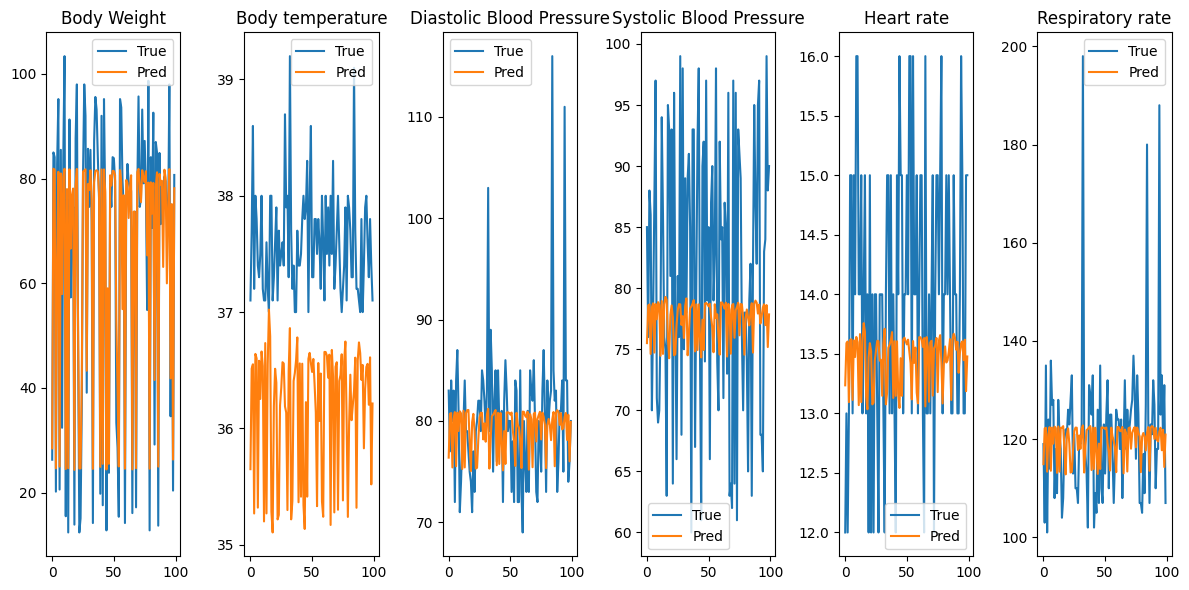

In [ ]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

plt.figure(figsize=(12,6))
for i, col in enumerate(vital_features[:6]):  # just first 3 vitals
    plt.subplot(1,6,i+1)
    plt.plot(y_test[:100,i], label="True")
    plt.plot(y_pred[:100,i], label="Pred")
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.layers import GRU

def build_stacked_gru(seq_len, n_features, hidden_units=64, dropout=0.3):
    model = Sequential([
        GRU(hidden_units, return_sequences=True, input_shape=(seq_len, n_features)),
        Dropout(dropout),
        GRU(hidden_units),
        Dense(32, activation="relu"),
        Dropout(dropout),
        Dense(y.shape[1])
    ])
    model.compile(optimizer=Adam(1e-3), loss="mse", metrics=["mae"])
    return model

gru_model1 = build_stacked_gru(SEQ_LEN, X.shape[2])
history = gru_model1.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=30,
                    batch_size=32,
                    verbose=1)

# Evaluation
loss, mae = gru_model1.evaluate(X_test, y_test, verbose=0)
print(f"Stacked GRU Test Loss: {loss:.4f}, MAE: {mae:.4f}")


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 5653.2334 - mae: 65.7561 - val_loss: 3760.5984 - val_mae: 51.3283
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2979.2473 - mae: 45.1318 - val_loss: 1029.3949 - val_mae: 24.9722
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 884.0754 - mae: 22.6895 - val_loss: 287.2231 - val_mae: 10.4636
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 479.2655 - mae: 15.7858 - val_loss: 223.3647 - val_mae: 8.9092
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 422.2458 - mae: 14.6083 - val_loss: 218.2316 - val_mae: 8.7718
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 413.4487 - mae: 14.3964 - val_loss: 213.7933 - val_mae: 8.6264
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 408.3163 - mae: 14.1638 - val_loss: 210.4481 - val_mae: 8.5647
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 405.8199 - mae: 13.9954 - val_loss: 211.7765 - val_mae: 8.7851
Epoch 9/30
88/88 ━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


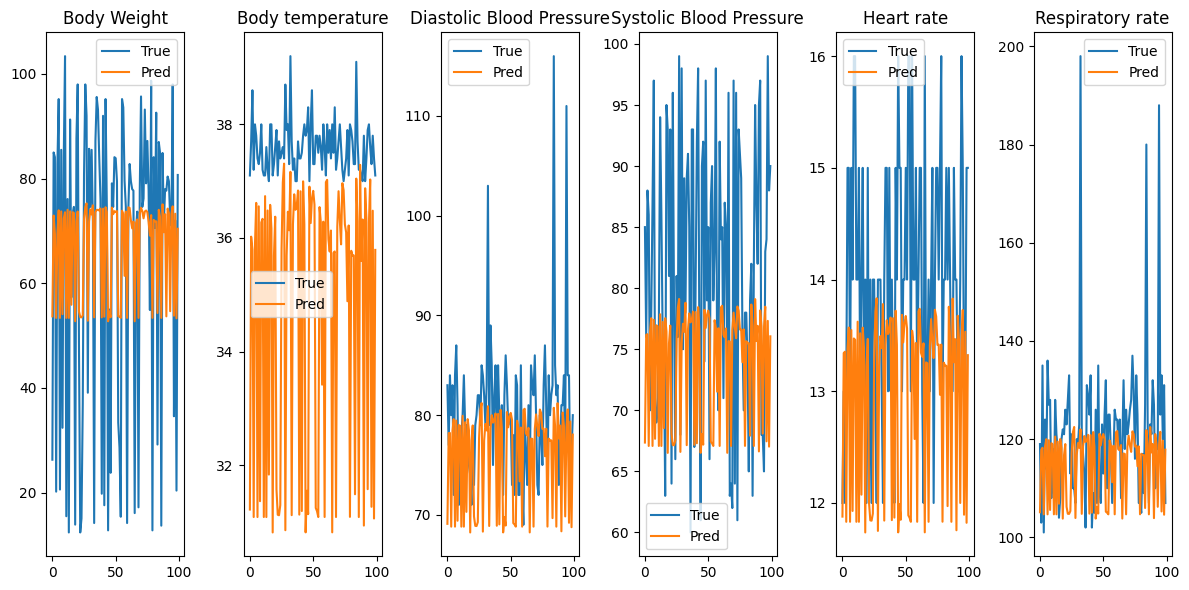

In [ ]:
import matplotlib.pyplot as plt

y_pred = gru_model1.predict(X_test)

plt.figure(figsize=(12,6))
for i, col in enumerate(vital_features[:6]):  # just first 3 vitals
    plt.subplot(1,6,i+1)
    plt.plot(y_test[:100,i], label="True")
    plt.plot(y_pred[:100,i], label="Pred")
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Attention, Input
from tensorflow.keras.models import Model

def build_lstm_with_attention(seq_len, n_features, hidden_units=64, dropout=0.3):
    inp = Input(shape=(seq_len, n_features))
    x = LSTM(hidden_units, return_sequences=True)(inp)
    x = Dropout(dropout)(x)
    x = LSTM(hidden_units, return_sequences=True)(x)

    attn = Attention()([x, x])  # self-attention
    x = tf.reduce_mean(attn, axis=1)  # global context

    x = Dense(32, activation="relu")(x)
    out = Dense(y.shape[1])(x)

    model = Model(inp, out)
    model.compile(optimizer=Adam(1e-3), loss="mse", metrics=["mae"])
    return model

ATT_lstm_model = build_stacked_gru(SEQ_LEN, X.shape[2])
history = ATT_lstm_model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=30,
                    batch_size=32,
                    verbose=1)

# Evaluation
loss, mae = ATT_lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Stacked ATT Test Loss: {loss:.4f}, MAE: {mae:.4f}")

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - loss: 5528.2471 - mae: 64.5331 - val_loss: 3386.2214 - val_mae: 47.3597
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2613.9800 - mae: 39.7884 - val_loss: 865.9109 - val_mae: 18.7247
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 807.8422 - mae: 20.1687 - val_loss: 322.8948 - val_mae: 10.9213
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 480.9359 - mae: 15.5933 - val_loss: 233.0455 - val_mae: 9.1465
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 419.3779 - mae: 14.4887 - val_loss: 215.1035 - val_mae: 8.5659
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 398.4526 - mae: 14.0653 - val_loss: 215.7399 - val_mae: 8.6978
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 402.0112 - mae: 13.9503 - val_loss: 216.3895 - val_mae: 8.7627
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 393.8852 - mae: 13.5729 - val_loss: 210.8762 - val_mae: 8.6455
Epoch 9/30
88/88 ━━━━━━━━━━━━

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


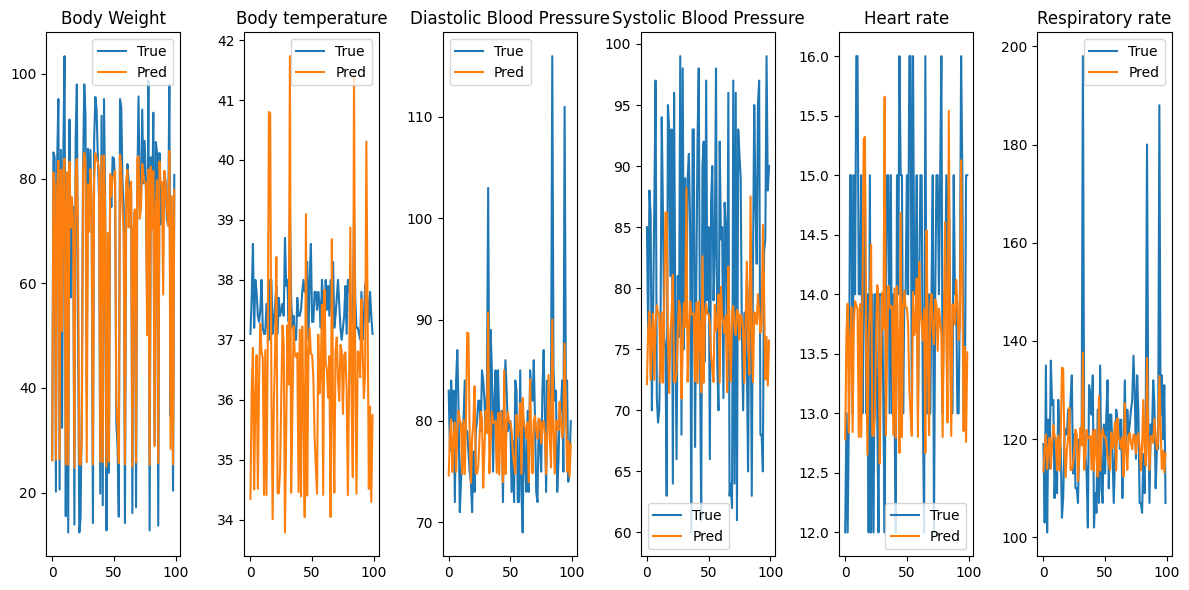

In [ ]:
import matplotlib.pyplot as plt

y_pred = ATT_lstm_model.predict(X_test)

plt.figure(figsize=(12,6))
for i, col in enumerate(vital_features[:6]):  # just first 3 vitals
    plt.subplot(1,6,i+1)
    plt.plot(y_test[:100,i], label="True")
    plt.plot(y_pred[:100,i], label="Pred")
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


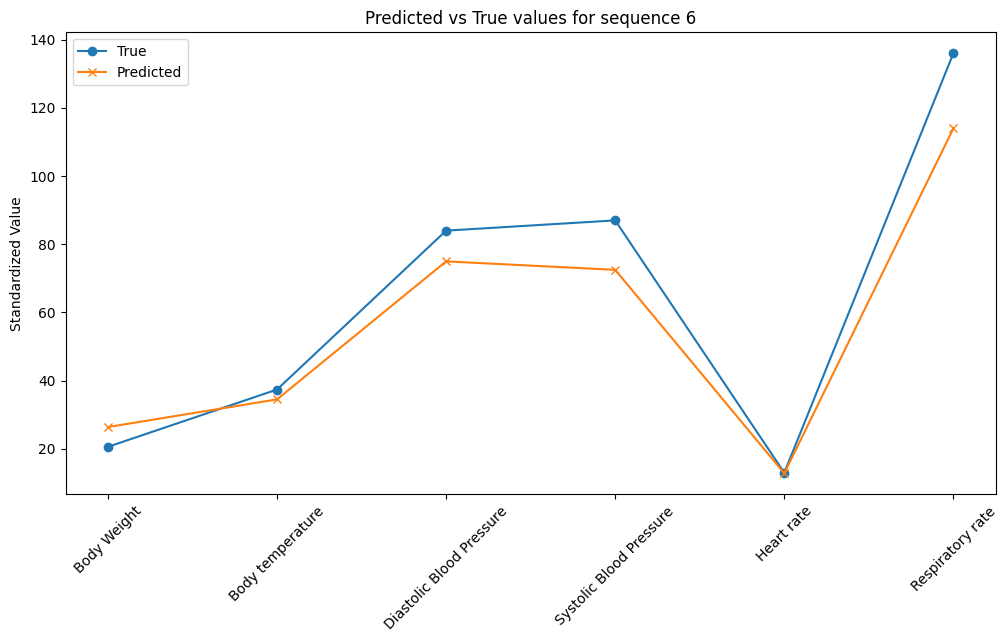

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Pick a patient or a sequence index to visualize
seq_idx = 6  # first sequence
#features = ["Body Weight", "Body temperature", "Diastolic BP", "Systolic BP",
           # "Heart rate", "Respiratory rate"]

y_true = y_test[seq_idx]
y_pred = ATT_lstm_model.predict(X_test[seq_idx:seq_idx+1])[0]

plt.figure(figsize=(12,6))
x = np.arange(len(vital_features))

plt.plot(x, y_true, marker='o', label="True")
plt.plot(x, y_pred, marker='x', label="Predicted")
plt.xticks(x, vital_features, rotation=45)
plt.ylabel("Standardized Value")
plt.title(f"Predicted vs True values for sequence {seq_idx}")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


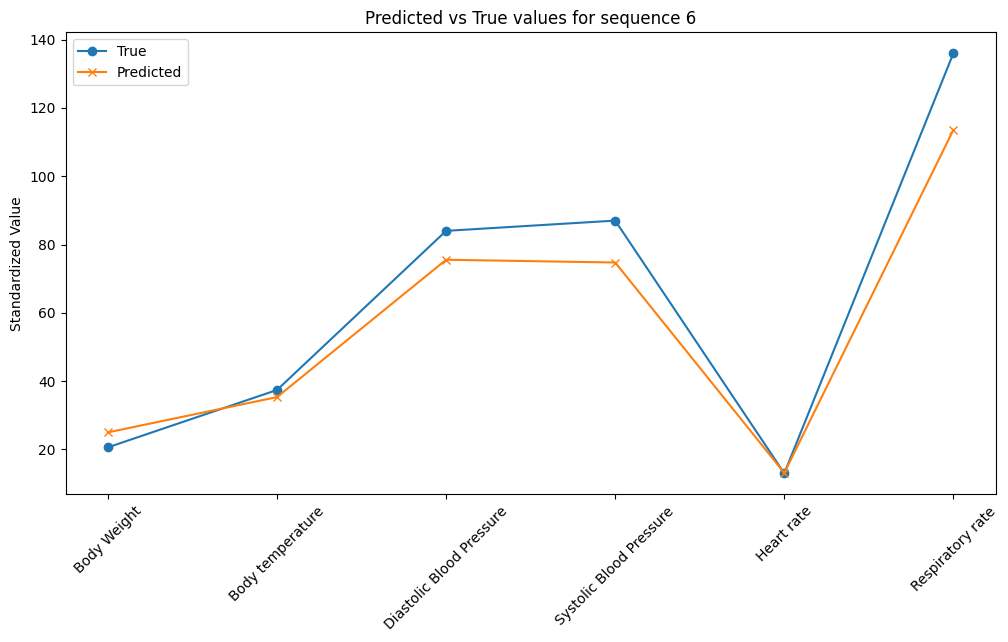

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Pick a patient or a sequence index to visualize
seq_idx = 6  # first sequence
#features = ["Body Weight", "Body temperature", "Diastolic BP", "Systolic BP",
           # "Heart rate", "Respiratory rate"]

y_true = y_test[seq_idx]
y_pred = model.predict(X_test[seq_idx:seq_idx+1])[0]

plt.figure(figsize=(12,6))
x = np.arange(len(vital_features))

plt.plot(x, y_true, marker='o', label="True")
plt.plot(x, y_pred, marker='x', label="Predicted")
plt.xticks(x, vital_features, rotation=45)
plt.ylabel("Standardized Value")
plt.title(f"Predicted vs True values for sequence {seq_idx}")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


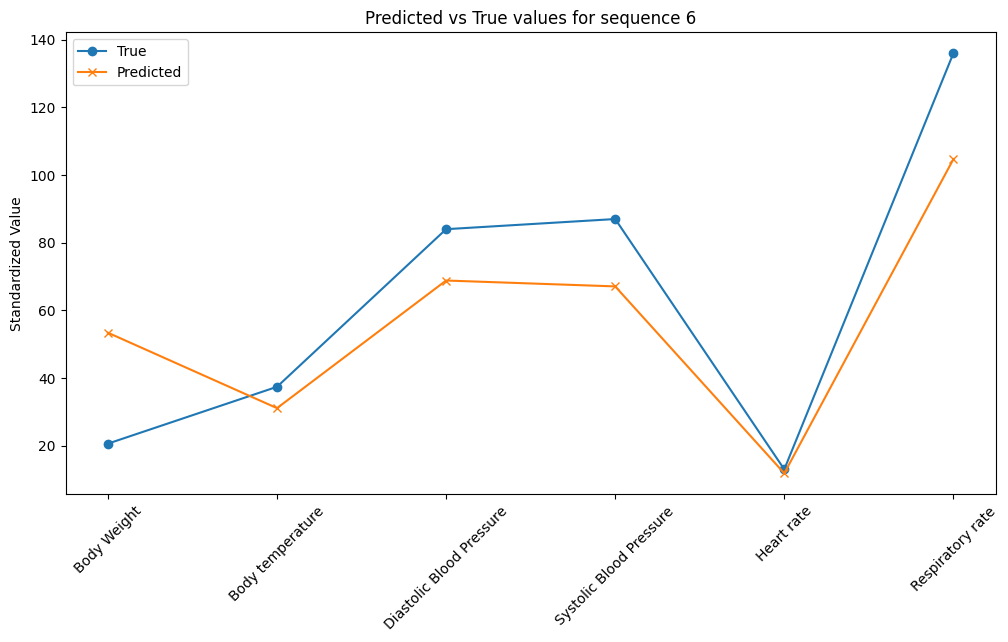

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Pick a patient or a sequence index to visualize
seq_idx = 6  # first sequence
#features = ["Body Weight", "Body temperature", "Diastolic BP", "Systolic BP",
           # "Heart rate", "Respiratory rate"]

y_true = y_test[seq_idx]
y_pred = gru_model1.predict(X_test[seq_idx:seq_idx+1])[0]

plt.figure(figsize=(12,6))
x = np.arange(len(vital_features))

plt.plot(x, y_true, marker='o', label="True")
plt.plot(x, y_pred, marker='x', label="Predicted")
plt.xticks(x, vital_features, rotation=45)
plt.ylabel("Standardized Value")
plt.title(f"Predicted vs True values for sequence {seq_idx}")
plt.legend()
plt.show()
